# Bonne pratique

## Les imports

## Les fonctions

## 

# Ce projet fonctionne avec les versions des package suivants:

- matplotlib==3.9.0
- pandas==2.2.2
- seaborn==0.13.2
- missingno==0.5.2
- scikit-learn==1.5.1

## The Data
This is a dataset of food products listing the ingredients and nutritional facts of more than 300,000 foods from over 150 countries in the world. The data is meant to be free to the public to help users decode food labels, and make better food choices in general. The dataset contains more than 300,000 rows over 163 columns. However, as we will see there are a lot of missing or obviously incorrect values.<br/>
Generalities:

- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product

Depuis le 26 juin 2024, la méthode de calcul du Nutri-Score a été mise à jour on peu en trouver les détails dans ce document:
- https://www.santepubliquefrance.fr/content/download/150262/file/FAQ-updatedAlgo-FR_20231222.pdf

En utilisant ce document, on peut selectionner les colonnes à conserver les plus pertinente.

In [405]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.api as sm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import tkinter as tk
from tkinter import filedialog
from tqdm import tqdm


import missingno as msno
import ipywidgets as widgets
from wordcloud import WordCloud
from IPython.display import display, HTML,clear_output

# Nettoyer et Filtrer les Features et Produits

## 1.1. Collecter et Préparer les Données Brutes
### 1. Charger les données dans un DataFrame Pandas

In [406]:
def project_init():
    global original_data, target
    display(HTML("<h1 style='color: white'>Open Food Facts</h1>"))
    print('Initialisation du projet...', end='\r')
    filepath ='datas/openfoodfacts.csv'
    target ='nutrition_grade_fr'
    original_data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
    print(' '*len('Initialisation du projet...'), end='\r')
    print('Projet chargé')
    return filepath, target, original_data

In [407]:
filepath, target, original_data= project_init()

Projet chargé              


In [408]:
def select_file():
    print("charger le nouveau fichier")
    root =tk.Tk()
    root.withdraw()

    filepath = filedialog.askopenfilename(
        title="Choisissez votre fichier csv",
        filetypes=(("Fichiers CSV","*.csv"), ("Tous les fichiers","*.*"))
    )
    print(' '*len("charger le nouveau fichier"),end='\r')
    print("chargement en cours...")
    root.destroy()

    if filepath:
        try:
            original_data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
            print(' '*len("chargement en cours..."),end='\r')
            print(f"Fichier chargé avec succès depuis le chemin: {filepath}")
            return original_data
        except Exeption as e:
            print("Erreur lors du chargement du fichier:",e)
    else:
        print("Aucun fichier sélectionné.")

In [409]:
def select_columns():
    negative_elements =['energy_100g','saturated-fat_100g','sugars_100g','salt_100g']
    positive_elements=['proteins_100g','fiber_100g','fruits-vegetables-nuts_100g']
    columns_to_keep =['code',target,'nutrition-score-fr_100g']
    if len(negative_elements)>1:
        for ne in negative_elements:
            columns_to_keep.append(ne)
    if len(positive_elements)>1:
        for pe in positive_elements:
            columns_to_keep.append(pe)
    return columns_to_keep,negative_elements,positive_elements

In [410]:
# Nettoie le dataset des valeur nulles de la cible
def clean_target(data, target):
    print(f'⏳ Nettoyage des données nulles de la cible {target}',end='\r')
    data=data.dropna(subset=[target])
    print(f' '*len(f'⏳ Nettoyage des données nulles de la cible {target}'),end='\r')
    print(f'✅ Données nulles de la cible {target} nettoyées')

    return data

In [411]:
def clean_duplicate(data):
    print(f"⏳ Nettoyage des doublons de la colonne 'code'",end='\r')
    data = data.drop_duplicates(subset=['code'])
    print(f' '*len("⏳ Nettoyage des doublons de la colonne 'code'"),end='\r')

    print(f"✅ Doublons de la colonne 'code' nettoyés")
    return data

In [412]:
def filter_columns(data):
    # Sélectionne les colonnes se terminant par '_100g'
    columns_to_filter = [col for col in data.columns if col.endswith('_100g')]
    
    if target not in columns_to_filter:
        columns_to_filter.append(target)
    # Filtrer les colonnes qui ont moins de 50% de valeurs NaN
    filtered_data = data[columns_to_filter].dropna(axis=1, thresh=len(data) * 0.5)
    
    return filtered_data

In [413]:
def split_features(data):
    quantitative_features = data.select_dtypes(include=['float64','int64'])
    qualitative_features = data.select_dtypes(include=['object'])
    return quantitative_features,qualitative_features

In [414]:
def boxplot_IQR(filtered_data, quantitative_features,IQR=False):
    if IQR:
        display(HTML("<h3 style='color: white'>Boxplot Après IQR</h3>"))
    else:
        display(HTML("<h3 style='color: white'>Boxplot AVANT IQR</h3>"))
    for col in quantitative_features:
        sns.boxplot(x=filtered_data[col])
        plt.title(f'Boxplot pour la Feature: {col}')
        plt.show()
    

In [415]:
def impossible_value(filtered_data,quantitative_features):
    data= filtered_data.copy()
    for col in quantitative_features.columns:
        if col in ['nutrition-score-fr_100g','nutrition-score-uk_100g']:
               data[col] = data[col].apply(lambda x: x if -15 <= x <= 40 else np.nan)
        else:
            data[col] = data[col].apply(lambda x: x if 0 <= x <= 100 else np.nan)
    return data

In [416]:
def remove_outliers(filtered_data, quantitative_features):
    data = filtered_data.copy()  # Faire une copie des données filtrées pour la manipulation
    for col in quantitative_features.columns:
        if 'energy' not in col:
            # Calcul des quartiles et de l'IQR en ignorant les NaN
            Q1 = filtered_data[col].quantile(0.25, interpolation='midpoint')
            Q3 = filtered_data[col].quantile(0.75, interpolation='midpoint')
            IQR = Q3 - Q1
            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR

            data = data[(data[col] >= lower_limit) & (data[col] <= upper_limit)]
            # print(f"Data size after removing outliers from {col}: {data.shape[0]}")
    return data

Pourquoi un model de regression?
model de regression = predit un chiffre (Prix de maison...)
model de classification = predit un classe (un chat ou un chien)
clusterisation = model non superviser et il se demerde

In [417]:
def find_best_k(data_cleaned,quantitative_features):

    print('Démarrage calcul best_n pour knn imputation...',end='\r')
    df=data_cleaned.copy()
    missing_before = df[quantitative_features.columns].isna().sum()

    # print(f'missing_before--> {missing_before}')
         
    knn_target = 'nutrition-score-fr_100g'
    for col in quantitative_features.columns:
        df[col]=pd.to_numeric(df[col],errors='coerce')
    # print(f'numericConversion\n{df[quantitative_features.columns].isna().sum()}')
    non_numeric_values = data_cleaned['energy_100g'][~data_cleaned['energy_100g'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()]

    best_n = 0
    best_score = np.inf
    model = LinearRegression()

    df_to_impute = df[quantitative_features.columns]
    # df_to_impute = df[df[target] != np.nan]
    
    for n in range(1, 10):
        knn_imputer = KNNImputer(n_neighbors=n)
        df_imputed = knn_imputer.fit_transform(df_to_impute) #! NO EMPTY TARGETS
        
        df_imputed = pd.DataFrame(df_imputed, columns=quantitative_features.columns) #! array to df
    
        X = df_imputed.drop(columns=[knn_target]) #! X = all sauf target
        y = df_imputed[knn_target] #! y = target only
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #! convention
        
        #! tjs fit, predict
        
        model.fit(X_train, y_train) #! apprend col + trget
        y_pred = model.predict(X_test) #! se demerde avec col pour trouver target
        mse = mean_squared_error(y_test, y_pred) #! compare target predit avec target reel
        if n ==1:
            print(' '*len('Démarrage calcul best_n pour knn imputation...'),end='\r')
        print(f"mse: {mse} with n={n}")
        if  mse < best_score:
            best_score = mse
            best_n = n
            print (f"new best mse: {mse} with n={n}")
    print(f"Final best mse={best_score} et Final best n={best_n}")        
    
    return best_n #! dataset complet imputé

In [418]:
def knn_impute(df,best_n):
    print('Demarrage imputation sur dataset initial')
    columns_to_keep,_,_=select_columns()
    columns_to_impute = [col for col in columns_to_keep if pd.api.types.is_numeric_dtype(df[col])]

    knn_imputer = KNNImputer(n_neighbors=best_n) #! reimpute avec le meilleur n
    
    df_imputed = knn_imputer.fit_transform(df[columns_to_impute]) #! sur df COMPLET
    
    df_imputed = pd.DataFrame(df_imputed, columns=columns_to_impute)

    df[columns_to_impute]= df_imputed

    print(' '*len('Demarrage imputation sur dataset originel'),end='\r')
    print('✅ imputation sur dataset initial fait')
    return df

### Map nutrition score vers lettre
Les seuil des différents score ont été trouvé sur : https://fr.wikipedia.org/wiki/Nutri-score

In [419]:
def map_nutrition_grade(data):
    print('Démarrage nutrition grade map',end='\r')
    def score_to_letter(score):
        if pd.isna(score):
            return None
        if -15<= score <= -2:
            return 'a'
        elif -1<= score <= 3:
            return 'b'
        elif 4 <= score <= 11:
            return 'c'
        elif 12 <= score <= 16:
            return 'd'
        else:
            return 'e'
    print(' '*len('Démarrage nutrition grade map'),end='\r')
    print('✅ Démarrage nutrition grade map fait')
    data['nutrition_grade_fr'] = data['nutrition-score-fr_100g'].apply(score_to_letter)
    return data

In [420]:
def find_best_n():
    print('Nettoyage et imputation du dataset')
    data = original_data.copy()
    # print(f'shape: {data.shape}')
    # print(f'Info:\n')
    # data.info()
    # print(f'Describe:\n {data.describe()}')
    data=clean_target(data, target)
    data=clean_duplicate(data)
    # print(data.columns)
    filtered_data= filter_columns(data)
    quantitative_features,qualitative_features=split_features(filtered_data)

    # # boxplot_IQR(filtered_data, quantitative_features, IQR=False)
    filtered_data= impossible_value(filtered_data,quantitative_features) # On retire les valeurs impossible du dataset filtré

    data_cleaned= remove_outliers(filtered_data,quantitative_features) # Traitement des outliers pour le calcul du best K
    # # boxplot_IQR(data_cleaned,quantitative_features ,IQR=True)

    best_n=find_best_k(data_cleaned,quantitative_features) # Calcul le best K pour l'imputation du KNN
    
    print('✅ Nettoyage et calcul du best n terminé')
    return best_n

In [421]:
best_n = find_best_n()

Nettoyage et imputation du dataset
✅ Données nulles de la cible nutrition_grade_fr nettoyées    
✅ Doublons de la colonne 'code' nettoyés     
mse: 0.029409773362865883 with n=1            
new best mse: 0.029409773362865883 with n=1
mse: 0.029404612945918843 with n=2
new best mse: 0.029404612945918843 with n=2
mse: 0.02940255869656205 with n=3
new best mse: 0.02940255869656205 with n=3
mse: 0.029403855962887075 with n=4
mse: 0.029400523840625276 with n=5
new best mse: 0.029400523840625276 with n=5
mse: 0.02939790288499641 with n=6
new best mse: 0.02939790288499641 with n=6
mse: 0.029399632273866064 with n=7
mse: 0.029398118896142904 with n=8
mse: 0.02939894766852526 with n=9
Final best mse=0.02939790288499641 et Final best n=6
✅ Nettoyage et calcul du best n terminé


In [422]:
quantitative_features,_=split_features(original_data)
data= impossible_value(original_data,quantitative_features) # On remplace les valeurs impossible par NaN du dataset complet pour faire les imputation ensuite
columns_to_keep,_,_=select_columns()

In [402]:
data= impossible_value(original_data,quantitative_features) # On remplace les valeurs impossible par NaN du dataset complet pour faire les imputation ensuite

In [435]:
data['nutrition_grade_fr'].value_counts()

nutrition_grade_fr
d    62763
c    45538
e    43030
a    35634
b    34245
Name: count, dtype: int64

In [436]:
df=knn_impute(data,best_n) #imputation sur l'ensemble du dataset

Demarrage imputation sur dataset initial
✅ imputation sur dataset initial fait    


In [448]:
df_before_map=df.copy()
df=map_nutrition_grade(df) # Mappage du nutrition_grade en fonction du df imputé

✅ Démarrage nutrition grade map fait


In [449]:
df['nutrition_grade_fr'].value_counts()

nutrition_grade_fr
c    120095
e     63827
b     56817
d     52562
a     27471
Name: count, dtype: int64

In [328]:
def impute(best_n):
    quantitative_features,_=split_features(original_data)
    data= impossible_value(original_data,quantitative_features) # On remplace les valeurs impossible par NaN du dataset complet pour faire les imputation ensuite
    df=knn_impute(data,best_n,quantitative_features) #imputation sur l'ensemble du dataset
    map_nutrition_grade(df) # Mappage du nutrition_grade en fonction du df imputé

## Analyse de la distribution des variables quantitatives

### Graph de distribtution des variables quantitatives

In [450]:
def analyze_distribution(data,quantitative_features):
    for col in quantitative_features.columns:
        plt.figure(figsize=(12,6))

        sns.histplot(data[col].dropna(),kde=True)
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col,fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.show()

        # Calculating basic metrics
        mean_value = data[col].mean()
        median_value = data[col].median()
        quantiles = data[col].quantile([0.25, 0.5, 0.75])
        
        print(f'{col} - Mean: {mean_value}, Median: {median_value}')
        print(f'Quantiles:')
        print(quantiles)
        print('---' * 10)

### Calcul de la dispertion en fonction de l'écart-type

In [451]:
def calculate_metrics(data,quantitative_features):
    metrics={}

    for col in quantitative_features.columns:
        std_dev =data[col].std() # Calcul de l'ecart type

        if std_dev > data[col].mean() * 0.5:
            central_tendency = data[col].median()
            measure= "mediane"
        else:
            central_tendency = data[col].mean()
            measure= "moyenne"
        metrics[col]={
            "Mesure choisie": measure,
            "Valeur": central_tendency,
            "Écart-type": std_dev
        }
    return metrics



Calcul de la Dispersion :</br>
 Utilisation de l’écart-type pour évaluer la dispersion. Si la dispersion est élevée (grande variabilité dans les données), la médiane peut être plus appropriée que la moyenne pour résumer les données.

### Analyse Bivaries

#### Pairplot
Le pairplot permet de visualiser les relations entre les variables numériques du jeu de données, tout en incluant les distributions univariées sur la diagonale.

In [452]:
def plot_pairplot(data, quantitative_features):
    sns.pairplot(data[quantitative_features.columns])
    plt.suptitle('Pairplot des variables quantitative', y=0.02)
    plt.show()

### Graph Numérique / Catégorielle

In [453]:
def plot_boxplot_numeric_categorical(data, quantitative_features, target):
    plt.figure(figsize=(10,6))
    sns.boxplot(x=target, y='fat_100g', data=data)
    plt.title(f'distribution de fat_100g en fonction de {target}')
    plt.show()

### Heatmap
La heatmap permet de visualiser les corrélations entre les variables quantitatives. Les valeurs de corrélation sont comprises entre -1 et 1, où -1 indique une corrélation négative parfaite et 1 une corrélation positive parfaite.

In [454]:
def plot_correlation_heatmap(data, quantitative_features, threshold = 0.5):
    correlation_matrix = data[quantitative_features.columns].corr()

    mask = (correlation_matrix< -threshold)| (correlation_matrix > threshold)
    plt.figure(figsize=(12,8))
    sns.heatmap(correlation_matrix[mask], annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Heatmap entre les variables quantitatives - Seuil d\'affichage {-threshold}, {threshold}')
    plt.show()

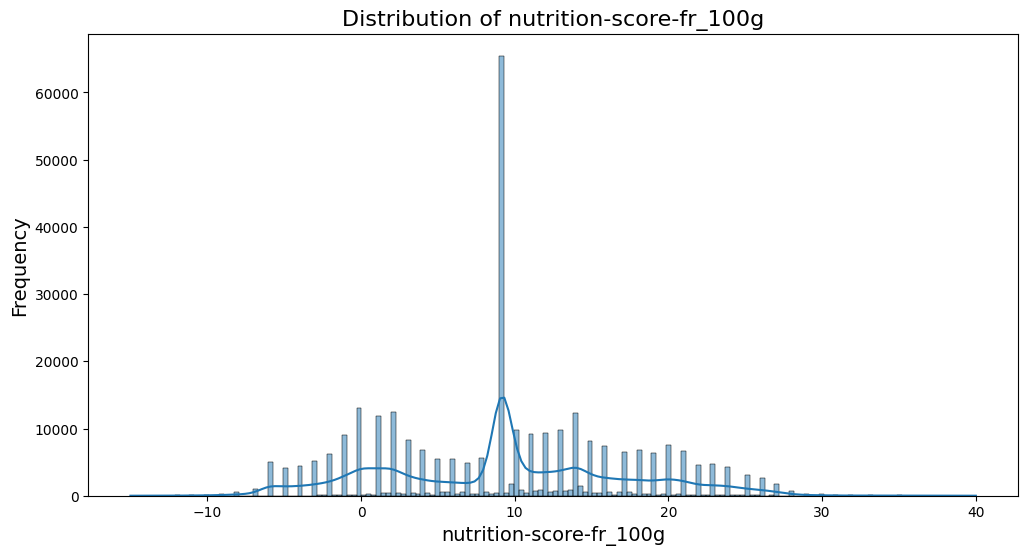

nutrition-score-fr_100g - Mean: 9.347728768504663, Median: 9.165535011979568
Quantiles:
0.25     3.000000
0.50     9.165535
0.75    14.000000
Name: nutrition-score-fr_100g, dtype: float64
------------------------------


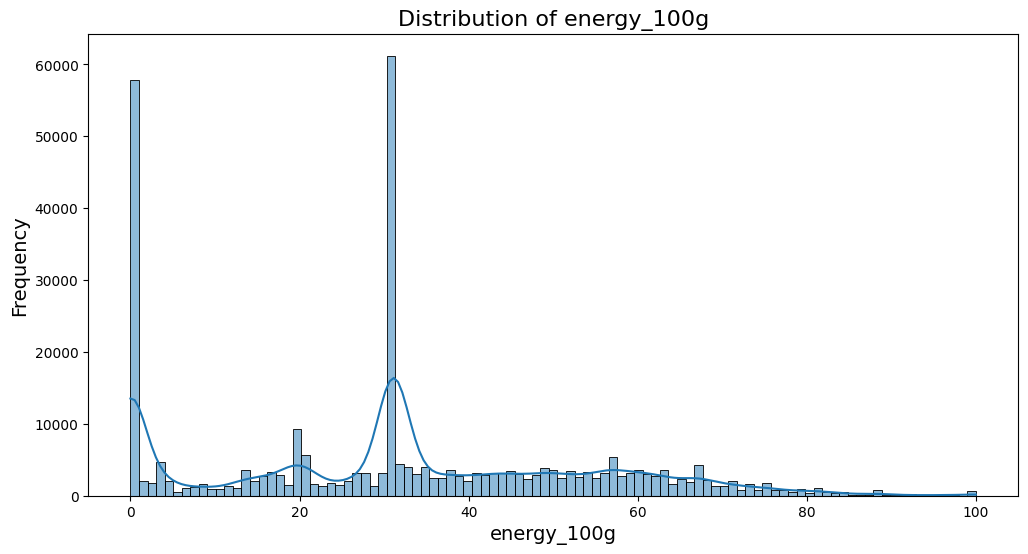

energy_100g - Mean: 31.560482124431772, Median: 31.077618268537528
Quantiles:
0.25    13.521667
0.50    31.077618
0.75    48.333333
Name: energy_100g, dtype: float64
------------------------------


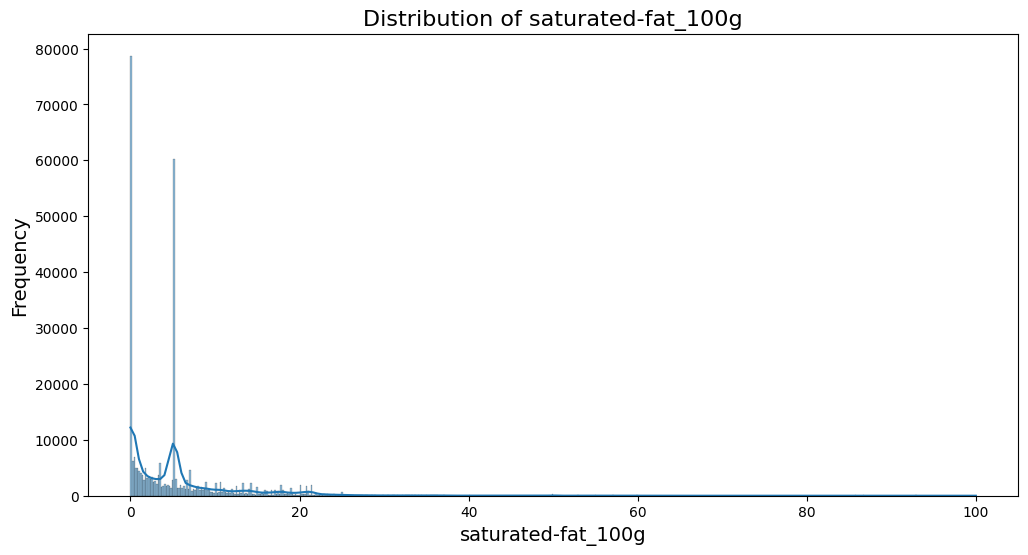

saturated-fat_100g - Mean: 5.610644598768315, Median: 4.5
Quantiles:
0.25    0.20
0.50    4.50
0.75    6.67
Name: saturated-fat_100g, dtype: float64
------------------------------


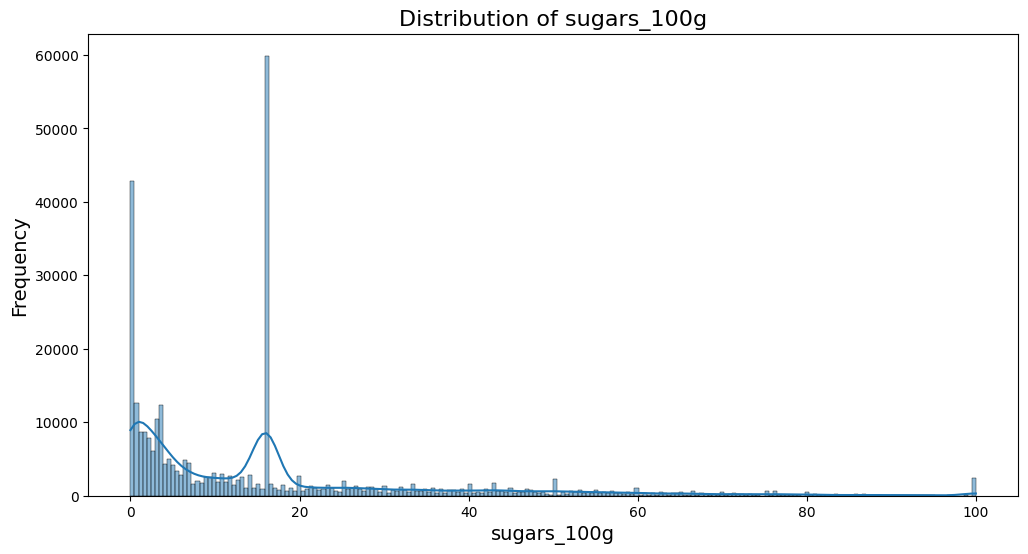

sugars_100g - Mean: 16.55237674828957, Median: 11.9
Quantiles:
0.25     2.4
0.50    11.9
0.75    18.9
Name: sugars_100g, dtype: float64
------------------------------


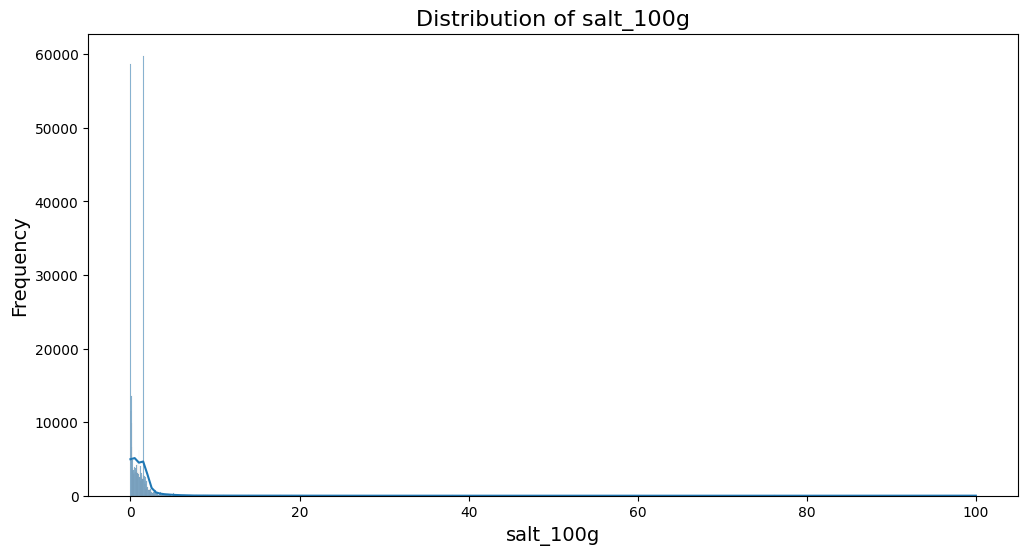

salt_100g - Mean: 1.5966626668709403, Median: 0.9017
Quantiles:
0.25    0.118000
0.50    0.901700
0.75    1.588497
Name: salt_100g, dtype: float64
------------------------------


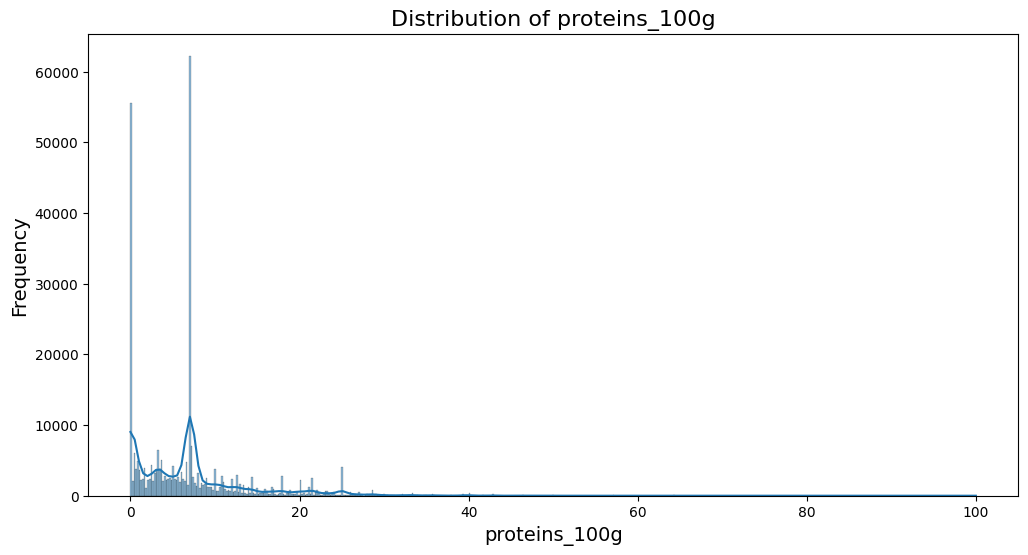

proteins_100g - Mean: 7.064179612360425, Median: 6.9
Quantiles:
0.25    1.54
0.50    6.90
0.75    8.33
Name: proteins_100g, dtype: float64
------------------------------


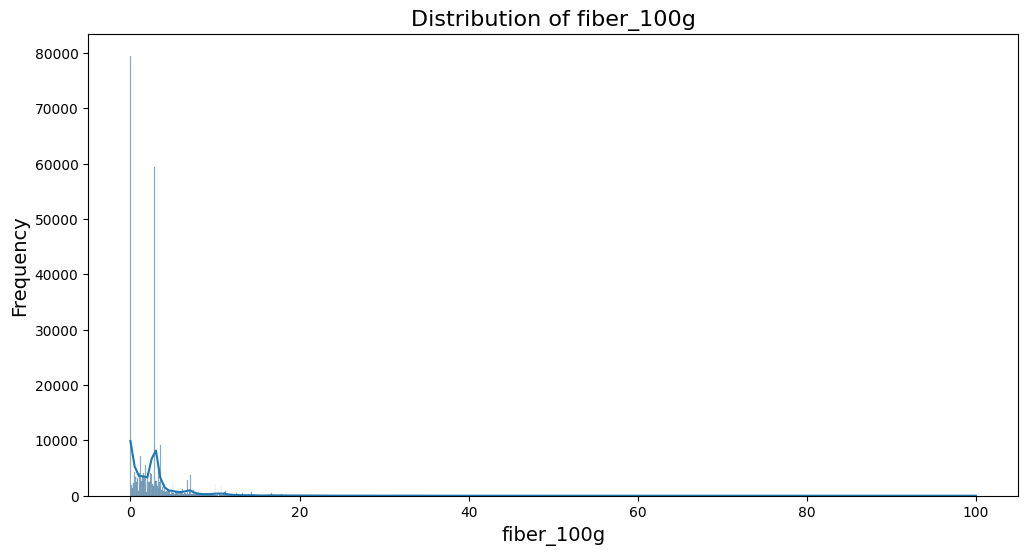

fiber_100g - Mean: 2.8728887605222853, Median: 2.4
Quantiles:
0.25    0.1
0.50    2.4
0.75    3.2
Name: fiber_100g, dtype: float64
------------------------------


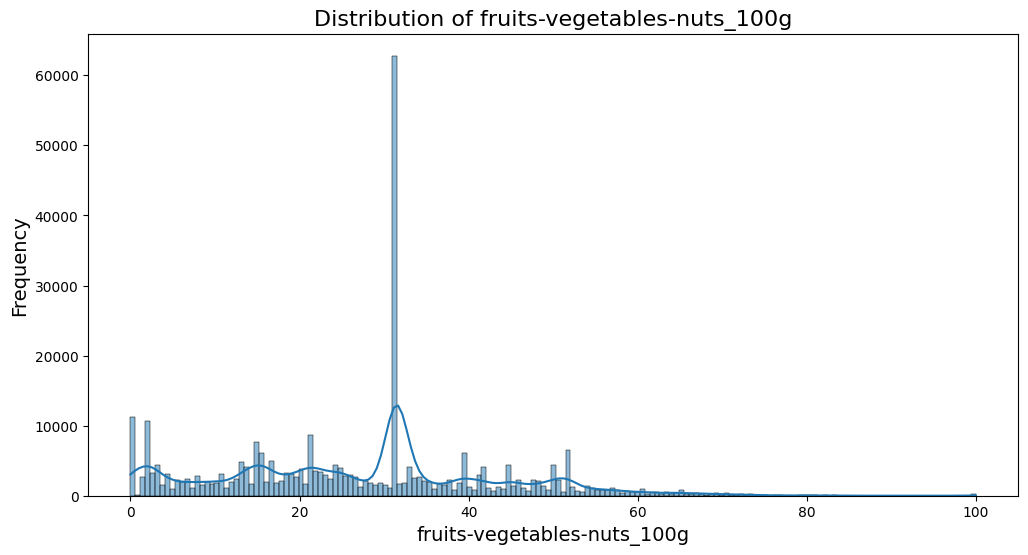

fruits-vegetables-nuts_100g - Mean: 27.1378931565822, Median: 30.116666666666664
Quantiles:
0.25    15.133333
0.50    30.116667
0.75    35.166667
Name: fruits-vegetables-nuts_100g, dtype: float64
------------------------------
Pour la colonne 'nutrition-score-fr_100g': 
- mediane: 9.165535011979568
- Écart-type: 7.864729535271473

Pour la colonne 'energy_100g': 
- mediane: 31.077618268537528
- Écart-type: 22.764494445775217

Pour la colonne 'saturated-fat_100g': 
- mediane: 4.5
- Écart-type: 7.4501175468098735

Pour la colonne 'sugars_100g': 
- mediane: 11.9
- Écart-type: 19.667149926363905

Pour la colonne 'salt_100g': 
- mediane: 0.9017
- Écart-type: 5.6101371960996165

Pour la colonne 'proteins_100g': 
- mediane: 6.9
- Écart-type: 7.354550250587991

Pour la colonne 'fiber_100g': 
- mediane: 2.4
- Écart-type: 4.023411042583475

Pour la colonne 'fruits-vegetables-nuts_100g': 
- mediane: 30.116666666666664
- Écart-type: 16.208048124748807



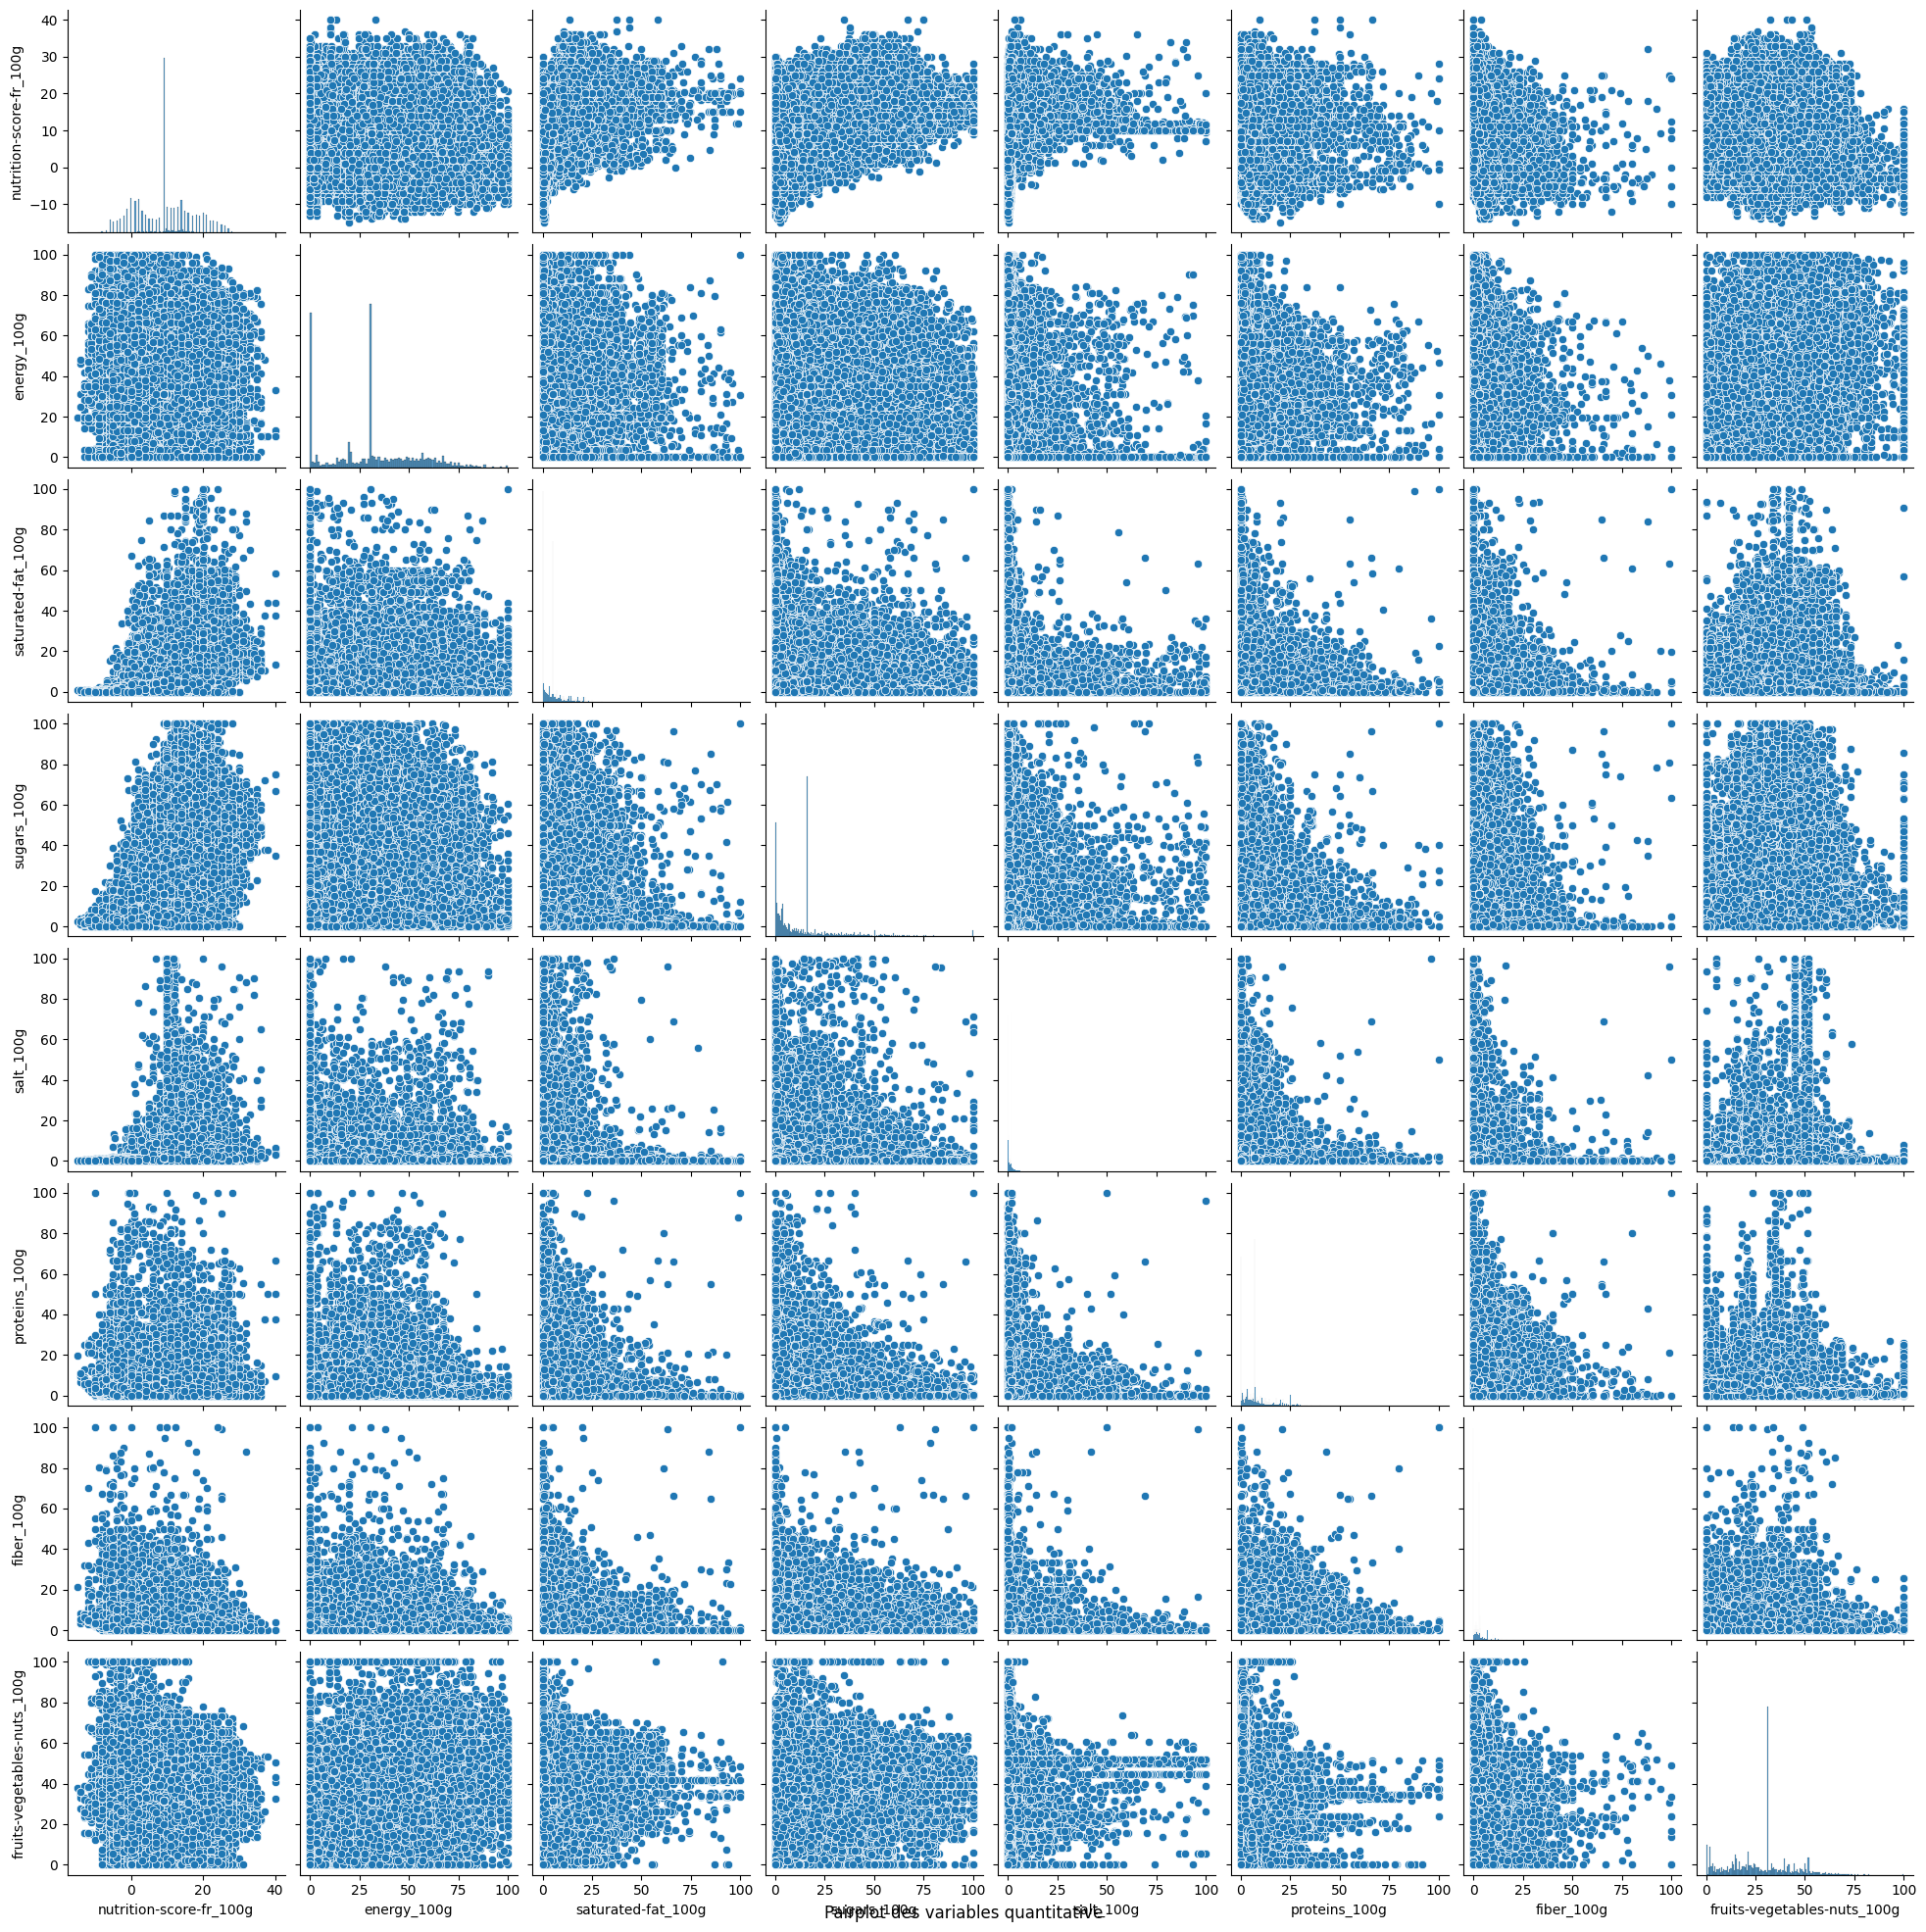

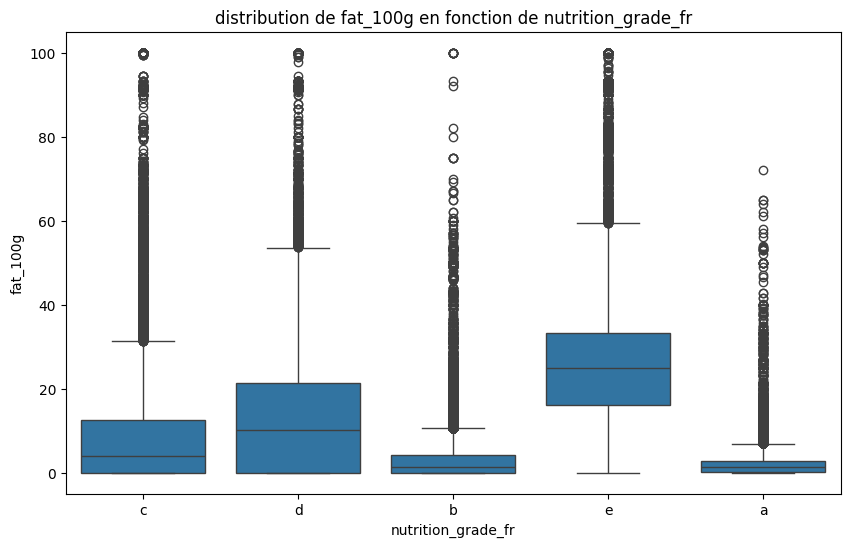

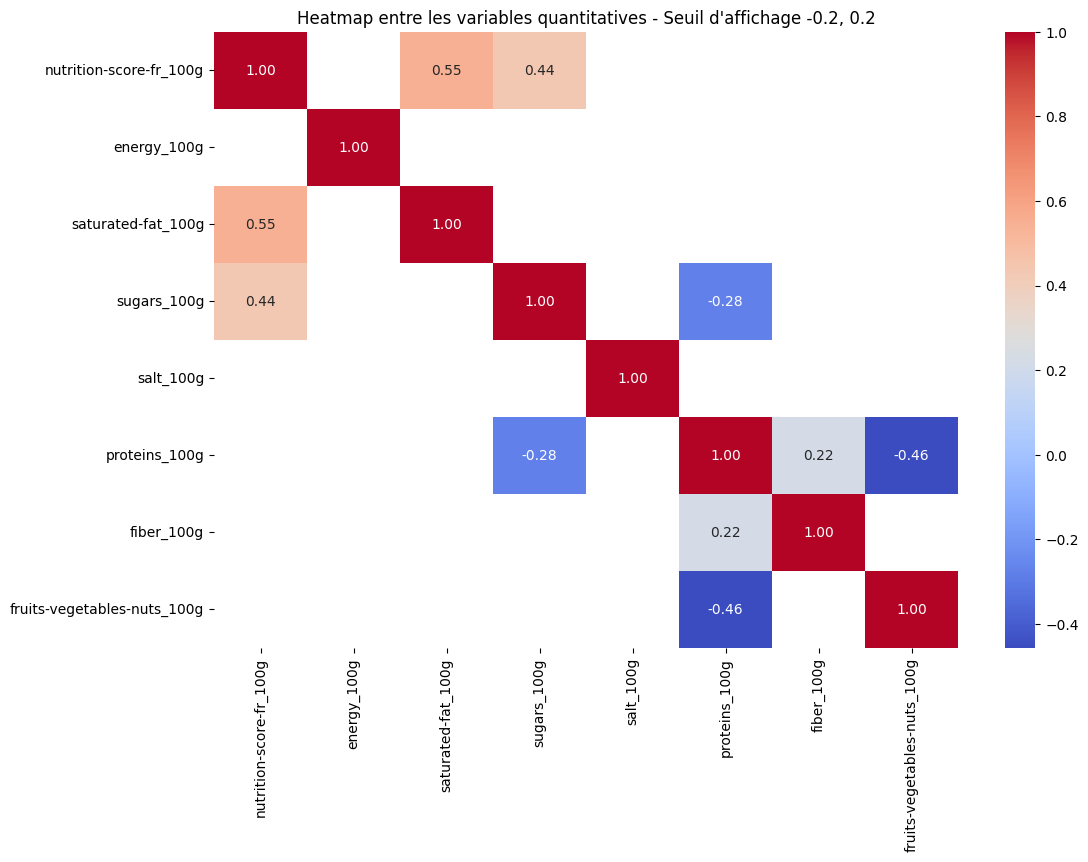

In [456]:
def analyze_uni_multi(df):
    columns_to_keep,_,_=select_columns()
    data_to_display = df[columns_to_keep]

    quantitative_features,qualitative_features=split_features(data_to_display)

    analyze_distribution(data_to_display,quantitative_features)
    metrics = calculate_metrics(df,quantitative_features)

    for col, info in metrics.items():
        print(f"Pour la colonne '{col}': ")
        print(f"- {info['Mesure choisie']}: {info['Valeur']}")
        print(f"- Écart-type: {info['Écart-type']}")
        print()

    plot_pairplot(df,quantitative_features)
    plot_boxplot_numeric_categorical(df,quantitative_features, target)
    plot_correlation_heatmap(df,quantitative_features, threshold=0.2)
analyze_uni_multi(df)